# Calculating Metrics to Evaluate VS performance

This notebook applies the different metrics reviewed in the previous notebook to the VS scoring results and predictions given by different docking tools.

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append(r'..')

In [2]:
from modules.plotting_metrics import PlotMetric

## Loading Docking Results
> ### Docking Score & Ligand Efficiency
First, we have to load the docking results, which were directly obtained from the docking tools. Then, we  also load the *Ligand Efficiency Scores*, which were calculated in a previous notebook and correspond to the quotient between *docking score* and the *number of heavy atoms* of each ligand.

Therefore, we load the data:

In [3]:
# CSAR DockingScores
docking_tools_csar = ['AD4_LE', 'AD4_LC', 'VINA', 'VINARDO']
csar_dk_Scores = {dk_tool: pd.read_csv(F'../data/vs_docking_crys_ensemble_{dk_tool}.csv', index_col=0)
                 for dk_tool in docking_tools_csar}
# CSAR Ligand Efficiency
csar_ligEff_Scores = {dk_tool: pd.read_csv(
    F'../data/docking_scores/vs_dk_CRYS_402_CSAR_{dk_tool}_ligand_Efficiency.csv', index_col=0)
                 for dk_tool in docking_tools_csar}

We also need to define the `y_true_csar` variable, which indicates if a given molecule is truly **active** (=1) or **inactive** (=0) accordingly to the experimental report. We also obtain the *pdb_ids* of all conformations.

In [4]:
# TRUE CSAR VALUES
y_true_csar = np.array(csar_dk_Scores['VINA'].ActiveInactive == "Active", dtype=int)
# PDB_IDS
pdb_ids = csar_dk_Scores['VINA'].drop('ActiveInactive', axis = 1).columns


## Evaluation of VS performance

Then we calculate the available metrics to evaluate the VS performance of the following:

### For CSAR:
1. **We have 402 CDK2 protein conformations**

- **We have 4 docking tools/methods**:
    - *AD4 LC*
    - *AD4 LE*
    - *VINA*
    - *VINARDO*
    
- **We have two different _ranking features_**:
    - *Docking Score*: The scores directly obtained from the each of the docking tools.
    - *Ligand Efficiency*: The quotient between *docking score* and the *number of heavy atoms* of each ligand.
    
- **We evaluate four different metrics**:
    - *ROC-AUC*
    - *BEDROC (alpha = 4)*
    - *Precision and Recall AUC*
    - *Normalized Enrichment Factor AUC*


This means that for each of the protein conformations we have calculated 8 different *rankings*, i.e., we evaluated each conformation with 4 docking tools/methods, following by applying two different *ranking features* (directly using the Dk score or by using Ligand Efficiency). And finally each one of these rankings is evaluated by 4 different metrics.

**The following function performs this task:**

In [5]:
def calc_vs_performance_metrics(ranking_scores_dfs, metrics, docking_tools, 
                                   y_true, bedroc_alpha, column_to_drop):
    results_dic = {}
    for ranking_score in ranking_scores_dfs.keys():
        for metric in metrics.keys():
            for dk_tool in docking_tools:
                rks = ranking_scores_dfs[ranking_score]
                y_preds_dic = rks[dk_tool].drop([column_to_drop], axis = 1).to_dict('list')
                scores = PlotMetric(y_true = y_true, y_pred_dict = y_preds_dic)
                # Now we get the name of the column
                col_name = F'{dk_tool}-{ranking_score}-{metric}'
                metric_to_use = metrics[metric]
                # Calculation of the respective metric
                if metric_to_use == 'bedroc': # If metric is BEDROC parse the alpha argument
                    metric_values = scores.format_metric_results(metric_to_use, 
                                                    alpha = bedroc_alpha).iloc[:,0].values
                else:
                    metric_values = scores.format_metric_results(metric_to_use).iloc[:,0].values
                results_dic[col_name] = metric_values
    # Returns a Dataframe of metric results
    return pd.DataFrame(results_dic, index = pdb_ids)

Then, we apply the fucntion over csar results.

In [6]:
# CSAR metrics results
docking_tools = docking_tools_csar
metrics = {'ROC': 'roc_auc', 'PrcRll': 'pr_auc', 'NEF': 'ref_auc', 'BEDROC': 'bedroc'}
column_to_drop = 'ActiveInactive'
ranking_scores_dfs = {'DkS': csar_dk_Scores, 'DkLEff': csar_ligEff_Scores}
bedroc_alpha = 4
y_true = y_true_csar

csar_dk_402confs_vs_metrics = calc_vs_performance_metrics(ranking_scores_dfs, metrics, docking_tools, 
                                              y_true, bedroc_alpha, column_to_drop)

As a result we got  a new DataFrame of 402 rows and 32 columns (4 dk tools *times* 2 ranking features *times* 4 evaluation metrics).

In [7]:
print('VS Performance in CSAR Dataset')
csar_dk_402confs_vs_metrics.head()

VS Performance in CSAR Dataset


,AD4_LE-DkS-ROC,AD4_LC-DkS-ROC,VINA-DkS-ROC,VINARDO-DkS-ROC,AD4_LE-DkS-PrcRll,AD4_LC-DkS-PrcRll,VINA-DkS-PrcRll,VINARDO-DkS-PrcRll,AD4_LE-DkS-NEF,AD4_LC-DkS-NEF,...,VINA-DkLEff-PrcRll,VINARDO-DkLEff-PrcRll,AD4_LE-DkLEff-NEF,AD4_LC-DkLEff-NEF,VINA-DkLEff-NEF,VINARDO-DkLEff-NEF,AD4_LE-DkLEff-BEDROC,AD4_LC-DkLEff-BEDROC,VINA-DkLEff-BEDROC,VINARDO-DkLEff-BEDROC
1aq1,0.637,0.726,0.575,0.730,0.491,0.554,0.273,0.407,0.691,0.763,...,0.582,0.625,0.856,0.890,0.775,0.826,0.748,0.806,0.682,0.723
1b38,0.642,0.694,0.546,0.678,0.402,0.481,0.278,0.352,0.671,0.726,...,0.541,0.636,0.802,0.808,0.763,0.822,0.690,0.692,0.656,0.720
1b39,0.465,0.525,0.581,0.765,0.209,0.249,0.400,0.553,0.483,0.554,...,0.553,0.729,0.700,0.733,0.785,0.873,0.553,0.572,0.676,0.790
1buh,0.573,0.660,0.535,0.708,0.343,0.475,0.287,0.398,0.616,0.702,...,0.488,0.625,0.810,0.849,0.733,0.811,0.702,0.752,0.620,0.699
1ckp,0.570,0.677,0.571,0.767,0.314,0.472,0.387,0.617,0.600,0.712,...,0.574,0.742,0.770,0.804,0.792,0.905,0.657,0.694,0.689,0.822


In [8]:
csar_dk_402confs_vs_metrics.shape

(402, 32)

### For DUD:
Pretty much like with CSAR, although DUD has been only evaluated with Vinardo.
1. **We have 402 CDK2 protein conformations**

- **We have 1 docking tools/methods**
    
- **We have two different _ranking features_**
    
- **We evaluated four different metrics**

In [9]:
# DUD DockingScores
docking_tools_dud = ['VINARDO']
dud_dk_Scores = {dk_tool: pd.read_csv(F'../data/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv', index_col=0)
                 for dk_tool in docking_tools_dud}
# DUD Ligand Efficiency
dud_ligEff_Scores = {dk_tool: pd.read_csv(
    F'../data/docking_scores/vs_dk_CRYS_402_DUD2006_{dk_tool}_ligand_Efficiency.csv', index_col=0)
                 for dk_tool in docking_tools_dud}

**True values of DUD.**

In [10]:
# TRUE CSAR VALUES
y_true_dud = np.array(dud_dk_Scores['VINARDO'].Actividad == "Active", dtype=int)

In [11]:
# DUD metrics results
docking_tools = docking_tools_dud
metrics = {'ROC': 'roc_auc', 'PrcRll': 'pr_auc', 'NEF': 'ref_auc', 'BEDROC': 'bedroc'}
column_to_drop = 'Actividad'
ranking_scores_dfs = {'DkS': dud_dk_Scores, 'DkLEff': dud_ligEff_Scores}
bedroc_alpha = 20
y_true = y_true_dud
    
dud_dk_402confs_vs_metrics = calc_vs_performance_metrics(ranking_scores_dfs, metrics, docking_tools, 
                                              y_true, bedroc_alpha, column_to_drop)

In [12]:
dud_dk_402confs_vs_metrics.head()

,VINARDO-DkS-ROC,VINARDO-DkS-PrcRll,VINARDO-DkS-NEF,VINARDO-DkS-BEDROC,VINARDO-DkLEff-ROC,VINARDO-DkLEff-PrcRll,VINARDO-DkLEff-NEF,VINARDO-DkLEff-BEDROC
1aq1,0.624,0.089,0.623,0.253,0.684,0.148,0.684,0.330
1b38,0.566,0.179,0.572,0.294,0.661,0.205,0.664,0.358
1b39,0.603,0.194,0.608,0.348,0.701,0.191,0.702,0.357
1buh,0.470,0.036,0.470,0.087,0.572,0.049,0.570,0.118
1ckp,0.639,0.132,0.639,0.330,0.732,0.147,0.730,0.348


# Visualization

The following functions will be used to plot the results previously obtained.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
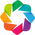

In [13]:
import holoviews as hv
from holoviews import dim
from bokeh.io import show
hv.extension('bokeh')

In [14]:
from auxiliar_plot_swarm import boxplot_metrics

## CSAR Databases vs 402 CDK2 conformations

In [15]:
f = boxplot_metrics(data = csar_dk_402confs_vs_metrics, 
                    title = "CSAR vs 402 CDK2 conformations")
show(f)

In [16]:
f = boxplot_metrics(data = dud_dk_402confs_vs_metrics, color_by= 'Ranking',
                    title = "DUD vs 402 CDK2 conformations: Vinardo")
show(f)

## ROC-AUC and Ligand Efficiency

In [17]:
from auxiliar_plot_swarm import plot_swarm_metrics, plot_swarm_pair

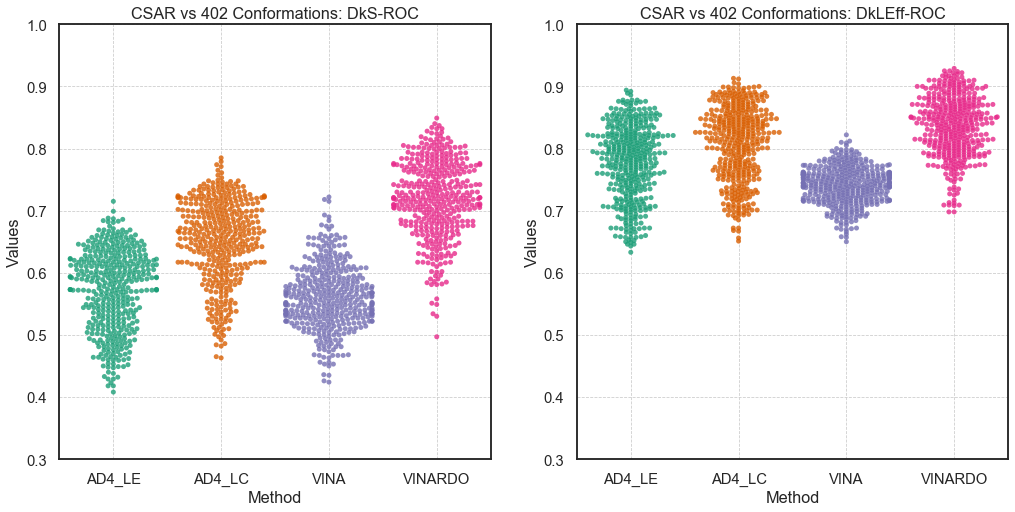

In [18]:
df = csar_dk_402confs_vs_metrics
hue = df['VINARDO-DkS-ROC'] > 0.8
plot_swarm_pair(df, title='CSAR vs 402 Conformations', metric='ROC', alpha = 0.8)

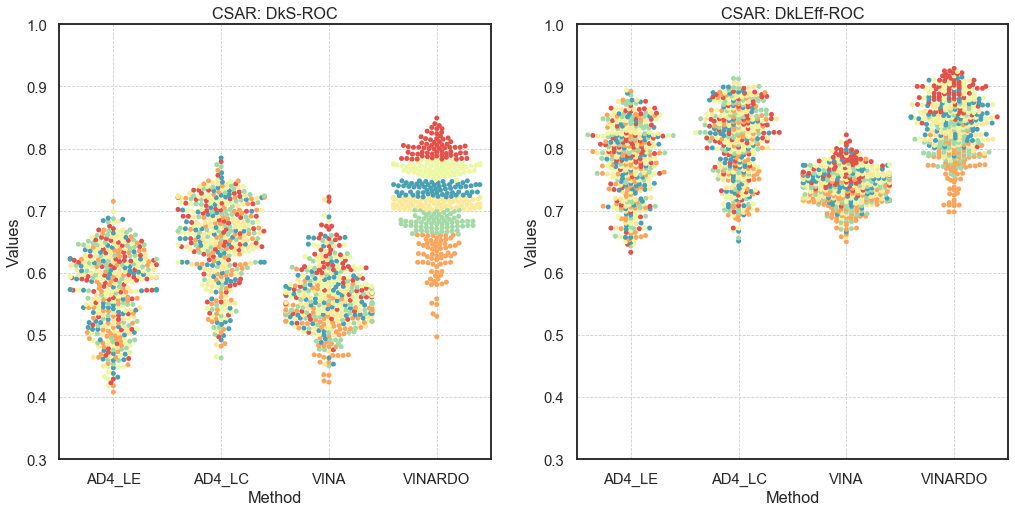

In [19]:
df = csar_dk_402confs_vs_metrics
hue = pd.qcut(df['VINARDO-DkS-ROC'], 6)
plot_swarm_pair(df, title='CSAR', metric='ROC', hue = hue, 
                legend = False, cmap = 'Spectral_r', alpha = 1)

In [20]:
df_1 = csar_dk_402confs_vs_metrics.filter(regex='-ROC', axis = 1).filter(regex='VINARDO', axis = 1)
df_1.columns = ['CSAR_DkS_ROC', 'CSAR_DkLEff_ROC']

df_2 = dud_dk_402confs_vs_metrics.filter(regex='-ROC', axis = 1).filter(regex='VINARDO', axis = 1)
df_2.columns = ['DUD_DkS_ROC', 'DUD_DkLEff_ROC']

df = pd.concat([df_1, df_2], axis = 1)
ds = hv.Dataset(df)

density_grid = gridmatrix(ds, diagonal_type=hv.Distribution, chart_type=hv.Bivariate)
point_grid = gridmatrix(ds, chart_type=hv.Points)

(density_grid * point_grid).opts(
    opts.Bivariate(bandwidth=0.5, cmap='Blues'), 
    opts.Points(size=2, tools=['box_select']))

NameError: name 'gridmatrix' is not defined